# Inversión FASE MT - RHOA SEDT

Importar librerías

In [1]:
import os
import numpy as np
from copy import deepcopy
from pathlib import Path
import pandas as pd
import inspect
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import tarfile
from scipy.constants import mu_0

#MTpy
from mtpy import MT, MTCollection, MTData

#SimPEG
from simpeg.electromagnetics import natural_source as nsem
import simpeg.electromagnetics.time_domain as tdem
from simpeg import maps
from simpeg.utils import plot_1d_layer_model, download, mkvc
from discretize import TensorMesh
from simpeg import (
    maps,
    data,
    data_misfit, 
    regularization,
    optimization,
    inverse_problem,
    inversion, 
    directives,
    utils,
)

mpl.rcParams.update({"font.size": 16})
from ipywidgets import interact, widgets
#from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from tkinter import Tk, Button, filedialog

import pygimli as pg
from pygimli.physics import em

Cargar datos MT y SEDT

In [2]:
# Cargar el archivo
dobs_MT = np.load("../FASE 1/MT/DatosMT.npy", allow_pickle=True).item()

# Extraer las variables
dobs = dobs_MT["dobs"]
frequencies = dobs_MT["frequencies"]

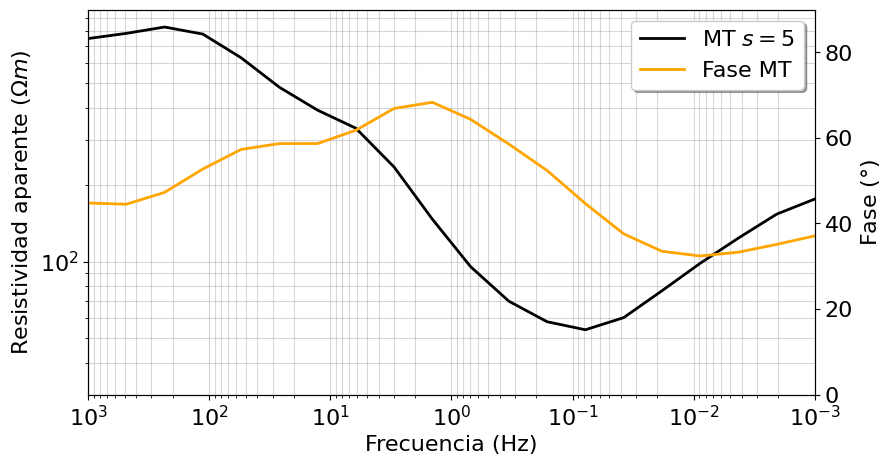

In [3]:
fig = plt.figure(figsize=(16, 5))
gs = gridspec.GridSpec(1, 5, figure=fig)

ax = fig.add_subplot(gs[0, 2:])
ax.loglog(frequencies, (5*dobs.reshape((len(frequencies), 2))[:,0]),  color='black', label='MT $\mathit{s}=5$', lw =2)
ax.loglog(frequencies[0], dobs.reshape((len(frequencies), 2))[0,0], color='orange', label='Fase MT',  lw =2)
ax.grid(True, which='both', alpha=0.5)
ax.set_ylabel(r"Resistividad aparente ($\Omega m$)")
ax.set_xlabel("Frecuencia (Hz)")  
ax.set_xlim(frequencies.max(), frequencies.min())

ax_1 = ax.twinx()
ax_1.plot(frequencies, dobs.reshape((len(frequencies), 2))[:,1], color='orange', lw = 2)  
ax_1.set_ylim(0, 90)    
ax_1.set_ylabel("Fase ($\degree$)")
ax.legend(loc='upper right', frameon=True, shadow=True, fancybox=True)
plt.show()

In [4]:
# Cargar el archivo
Datos_SEDT = np.load("../FASE 1/MT/DatosSEDTdbdt.npy", allow_pickle=True).item()

# Extraer las variables
dobsTDEM = Datos_SEDT["dobsTDEM"]
times = Datos_SEDT["times"]

In [5]:
dobs_HM = dobsTDEM[:25]
dobs_LM = dobsTDEM[25:]

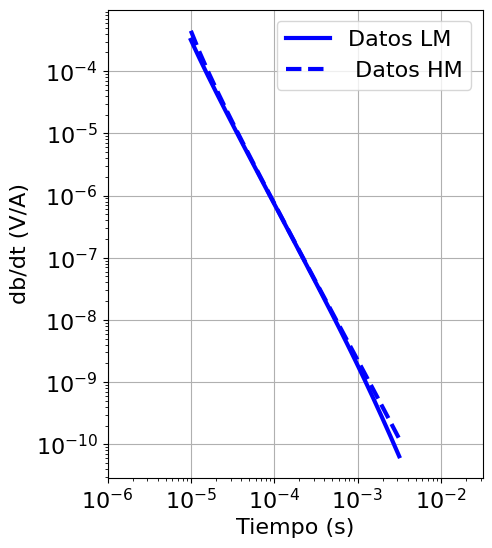

In [6]:
fig = plt.figure(figsize=(5, 6))
ax = fig.add_axes([0.2, 0.15, 0.75, 0.78])
ax.loglog(times, -dobs_LM, "b-", lw=3, label='Datos LM')
ax.loglog(times, -dobs_HM, "b--", lw=3, label=' Datos HM')

ax.set_xlim([times.min()/10, 10*times.max()])
#ax.set_ylim([1e-12, 1e-2])

ax.grid()
ax.set_xlabel("Tiempo (s)")
ax.set_ylabel("db/dt (V/A)")
#ax.set_title("Magnetic Flux Time Derivative")
ax.legend()
plt.show()

In [7]:
#Asignar incertidumbres a los datos

uncertaintiesTDEM = 0.01 * np.abs(dobsTDEM) * np.ones(np.shape(dobsTDEM))

phase = dobs.reshape((len(frequencies), 2))[:, 1] 
uncertaintiesMT = np.abs(phase) * 0.01

Definir los survey MT y SEDT

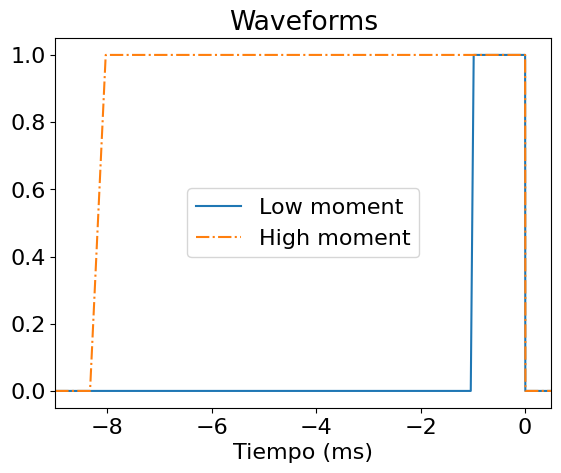

In [8]:
# Definir waveform

# Low moment
lm_waveform_times = np.r_[-1.041E-03, -9.850E-04, 0.000E+00, 4.000E-06]
lm_waveform_current = np.r_[0.0, 1.0, 1.0, 0.0]

# High moment
hm_waveform_times = np.r_[-8.333E-03, -8.033E-03, 0.000E+00, 5.600E-06]
hm_waveform_current = np.r_[0.0, 1.0, 1.0, 0.0]

plt.figure()
plt.title('Waveforms')
plt.plot(np.r_[-9, lm_waveform_times*1e3, 2], np.r_[0, lm_waveform_current, 0],
         label='Low moment')
plt.plot(np.r_[-9, hm_waveform_times*1e3, 2], np.r_[0, hm_waveform_current, 0],
         '-.', label='High moment')
plt.xlabel('Tiempo (ms)')
plt.xlim([-9, 0.5])
plt.legend()
plt.show()

waveform_LM = tdem.sources.PiecewiseLinearWaveform(
    times=lm_waveform_times, currents=lm_waveform_current
)

waveform_HM = tdem.sources.PiecewiseLinearWaveform(
    times=hm_waveform_times, currents=hm_waveform_current
)

# Receptores

receiver_location = np.array([0, 0, 0])
receiver_orientation = "z"  # "x", "y" or "z"

tiempo = np.logspace(-5,-2.5,25)
times = tiempo.copy()

receiver_list = []
receiver_list.append(
    tdem.receivers.PointMagneticFluxTimeDerivative(
        receiver_location, times, orientation=receiver_orientation
    )
)

# Fuente

source_location = np.array([
    [-20, -20, 0],        # Vértice 1 (punto de inicio)
    [20, -20, 0],     # Vértice 2
    [20, 20, 0],  # Vértice 3
    [-20, 20, 0],     # Vértice 4
    [-20, -20, 0]         # Cerrar el bucle (vuelve al punto de inicio)
])

source_list = [tdem.sources.LineCurrent(
        receiver_list=receiver_list,
        location=source_location,
        waveform=waveform_HM,),

        tdem.sources.LineCurrent(
        receiver_list=receiver_list,
        location=source_location,
        waveform=waveform_LM,)
]

# Definir el arreglo
surveyTDEM = tdem.Survey(source_list)

In [9]:
receivers_list = [
    nsem.receivers.PointNaturalSource(component="phase")
    ]

source_list = []
for freq in frequencies:
    source_list.append(nsem.sources.Planewave(receivers_list, freq))
        
surveyMT = nsem.survey.Survey(source_list)

In [10]:
# Definir los datos
data_objectMT = data.Data(surveyMT, dobs=phase, standard_deviation=uncertaintiesMT)
data_objectTDEM = data.Data(surveyTDEM, dobs=dobsTDEM, standard_deviation=uncertaintiesTDEM)

In [11]:
# Definir la malla
dz = 20
n_layer = 24
z_factor = 1.2
layer_thicknesses_inv = dz*z_factor**np.arange(n_layer-1)[::-1]

mesh_inv = TensorMesh([(np.r_[layer_thicknesses_inv, layer_thicknesses_inv[-1]])], "N")
mesh_inv

TensorMesh: 24 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     24     -6,544.74         -0.00     20.00  1,104.12    1.20

In [12]:
# Definir modelo inicial

rho_0 = 100 #100
rho_ref = 100 #100

# Modelo inicial
m0 = np.ones(len(layer_thicknesses_inv)+1) * np.log(1./rho_0)

# Modelo de referencia
mref = np.ones(len(layer_thicknesses_inv)+1) * np.log(1./rho_ref) 

In [13]:
# Definir la física

sigma_map = maps.ExpMap(nP=len(layer_thicknesses_inv)+1)

simulationMT = nsem.simulation_1d.Simulation1DRecursive(
    survey=surveyMT, 
    sigmaMap=sigma_map,
    thicknesses=layer_thicknesses_inv,
    )

simulationTDEM = tdem.Simulation1DLayered(
    survey=surveyTDEM,
    sigmaMap=sigma_map,
    thicknesses=layer_thicknesses_inv,
)

In [14]:
# Definir el desajuste de los datos
dmisMT = data_misfit.L2DataMisfit(simulation=simulationMT, data=data_objectMT)
dmisTDEM = data_misfit.L2DataMisfit(simulation=simulationTDEM, data=data_objectTDEM)

dmis = dmisMT + dmisTDEM

In [15]:
# Definir la regularización
reg = regularization.Sparse(
    mesh_inv, alpha_s=1e-10, alpha_x=1, reference_model=mref, mapping=maps.IdentityMap(mesh=mesh_inv))

In [16]:
# Definir la optimización
opt = optimization.InexactGaussNewton(maxIter=15, maxIterCG=30)

In [17]:
# Definir el problema inverso
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

In [18]:
# Definir las directivas de inversión
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=0.1)
beta_schedule = directives.BetaSchedule(coolingFactor=2, coolingRate=1)
save_dictionary = directives.SaveOutputDictEveryIteration()
save_dictionary.outDict = {}
# Setting a stopping criteria for the inversion.
#target_misfit = directives.TargetMisfit(chifact=1)

# The directives are defined as a list.
directives_list = [starting_beta, beta_schedule, save_dictionary]

In [19]:
# Combinar el problema inverso y las directivas
inv = inversion.BaseInversion(inv_prob, directives_list)

# Ejecutar la inversión
recovered_model = inv.run(m0)


Running inversion with SimPEG v0.23.0

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DRecursive problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  9.28e+04  2.15e+05  0.00e+00  2.15e+05    3.36e+05      0              
   1  4.64e+04  2.08e+04  2.31e-07  2.08e+04    1.62e+05      1              
   2  2.32e+04  1.20e+04  3.21e-07  1.20e+04    2.16e+04      0   Skip BFGS  
   3  1.16e+04  2.60e+03  9.13e-03  2.71e+03    3.01e+03      0              
   4  5.80e+03  2.05e+02  1.01e-02  2.63e+02    6.32e+02      0              
   5  2.90e+03  4.70e+01  1.49e-02  9.02e+01    2.23e+02      0   Skip

Datos MT

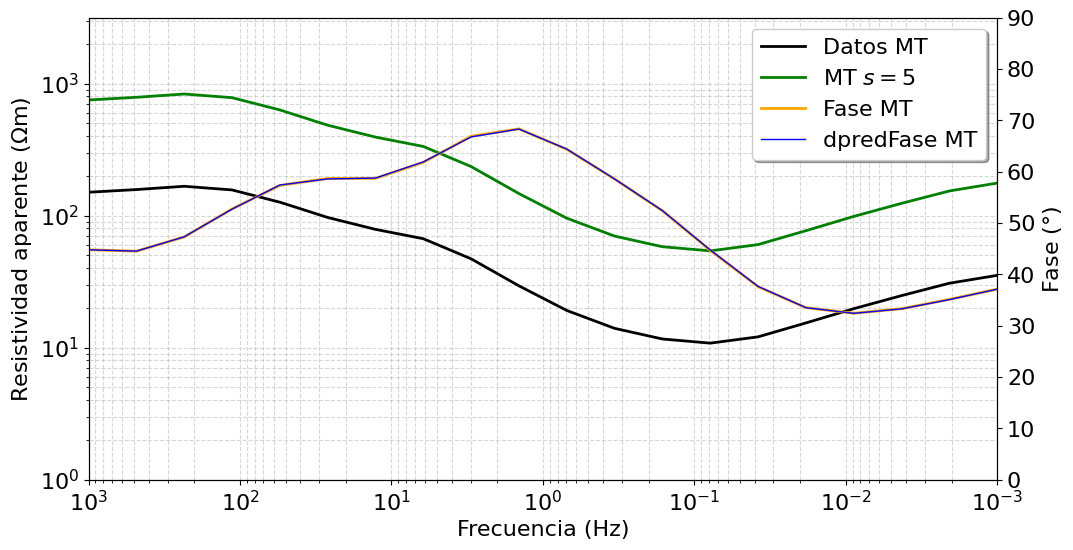

In [20]:
dpredMT= simulationMT.dpred(recovered_model)

fig = plt.figure(figsize=(20, 6))
gs = gridspec.GridSpec(1, 5, figure=fig)

# Segundo subplot: Datos observados y predichos
ax = fig.add_subplot(gs[0, 2:])
ax.loglog(frequencies, dobs.reshape((len(frequencies), 2))[:, 0], color='black', label="Datos MT", lw=2)
ax.loglog(frequencies, (5*dobs.reshape((len(frequencies), 2))[:,0]),  color='green', label='MT $\mathit{s}=5$', lw =2)
ax.loglog(frequencies[0], dobs.reshape((len(frequencies), 2))[0,0], color='orange', label='Fase MT',  lw =2)
ax.loglog(frequencies[0], dpredMT[0], color='blue', label='dpredFase MT',  lw =1)
#ax.loglog(frequencies, dpredMT, color='blue', label='dpredMT', lw=2)
#ax.loglog(1./frequencies, (5*dobs.reshape((len(frequencies), 2))[:, 0]), color='green', label='$\mathit{s}=5$', lw=2)
#ax.loglog(1./frequencies, (1/5*dobs.reshape((len(frequencies), 2))[:, 0]), color='red', label='$\mathit{s}=0.2$', lw=2)
ax.set_xlabel("Frecuencia (Hz)")
ax.set_ylabel("Resistividad aparente ($\Omega$m)")
ax.set_xlim(frequencies.max(), frequencies.min())

ax_1 = ax.twinx()
ax_1.plot(frequencies, dobs.reshape((len(frequencies), 2))[:,1], color='orange', lw = 2, label="Fase MT")  
ax_1.plot(frequencies, dpredMT, color='blue', label='dpredMT', lw=1)
ax_1.set_ylim(0, 90)    
ax_1.set_ylabel("Fase ($\degree$)")
ax.legend(loc='upper right', frameon=True, shadow=True, fancybox=True)

ax.grid(True, which="both", linestyle='--', alpha=0.5) 
ax.set_ylim([10**0, 10**3.5])

plt.show()

Datos SEDT

In [21]:
dpredTDEM = simulationTDEM.dpred(recovered_model)

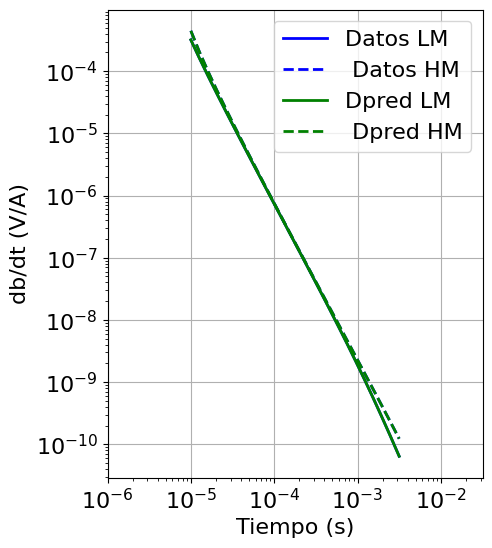

In [37]:
fig = plt.figure(figsize=(5, 6))
ax = fig.add_axes([0.2, 0.15, 0.75, 0.78])

ax.loglog(times, -dobs_LM, "b-", lw=2, label='Datos LM')
ax.loglog(times, -dobs_HM, "b--", lw=2, label=' Datos HM')

dpredTDEM_LM = dpredTDEM[25:]
dpredTDEM_HM = dpredTDEM[:25]
ax.loglog(times, -dpredTDEM_LM, "g-", lw=2, label='Dpred LM')
ax.loglog(times, -dpredTDEM_HM, "g--", lw=2, label=' Dpred HM')

ax.set_xlim([times.min()/10, 10*times.max()])
#ax.set_ylim([1e-12, 1e-2])

ax.grid()
ax.set_xlabel("Tiempo (s)")
ax.set_ylabel("db/dt (V/A)")
#ax.set_title("Magnetic Flux Time Derivative")
ax.legend()
plt.show()

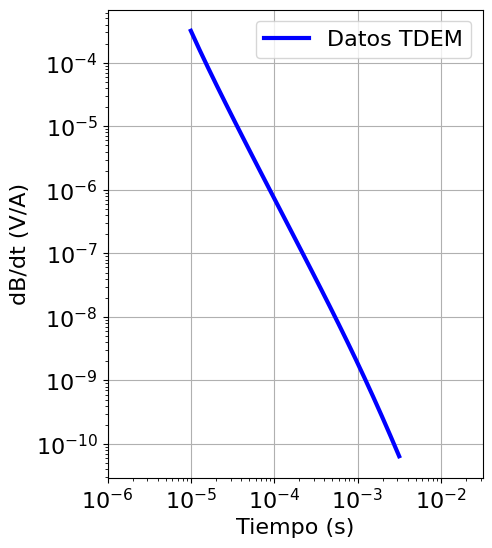

In [38]:
from scipy import interpolate
x = np.concatenate((times, times))
y = np.concatenate((-dpredTDEM_HM, -dpredTDEM_LM))
f = interpolate.interp1d(x, y)

times_ok = np.logspace(np.log10(np.min(times)),np.log10(np.max(times)),25)
dpredTDEM_ok = f(times_ok)   # use interpolation function returned by `interp1d`



fig = plt.figure(figsize=(5, 6))
ax = fig.add_axes([0.2, 0.15, 0.75, 0.78])
ax.loglog(times_ok, dpredTDEM_ok, "b-", lw=3, label='Datos TDEM')
#ax.loglog(xnew, ynew, "r--", lw=3, label='dpred_HM')

#ax.loglog(time_LM, dobs_LM, "b.",  label='dobs_LM')
#ax.loglog(time_HM, dobs_HM, "r.", label='dobs_HM')

ax.set_xlim([times.min()/10, 10*times.max()])
#ax.set_ylim([1e-12, 1e-2])

ax.grid()
ax.set_xlabel("Tiempo (s)")
ax.set_ylabel("dB/dt (V/A)")
#ax.set_title("Magnetic Flux Time Derivative")
ax.legend()
plt.show()

In [39]:
from pygimli.physics.em import rhoafromU

In [40]:
rhoa_TDEM = rhoafromU(U= dpredTDEM_ok, t= times_ok, Tx= 10000, Rx= 0.8)

In [41]:
fdpred = 0.194 / times

Modelo del subsuelo

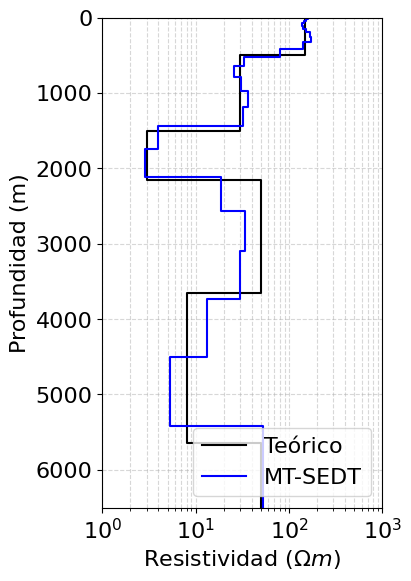

In [23]:
# Plot true model and recovered model
fig = plt.figure(figsize=(4, 7))

layer_tops = np.r_[0., -500., -1500., -2150., -3650., -5650.][::-1]  # in m
layer_thicknesses = np.diff(layer_tops)
rho_layers = np.r_[150., 30, 3., 50., 8., 50.][::-1]


ax1 = fig.add_axes([0.2, 0.15, 0.7, 0.7])
plot_1d_layer_model(layer_thicknesses[::-1], rho_layers[::-1], ax=ax1, color="k", label = "Teórico")
plot_1d_layer_model(
    layer_thicknesses_inv[::-1], (1/(sigma_map*recovered_model))[::-1], ax=ax1, color="b", label = "MT-SEDT"
)
ax1.grid()
ax1.set_xlabel(r"Resistividad ($\Omega m$)")
ax1.set_ylabel(r"Profundidad (m)")
#x_min, x_max = 1/true_conductivities.min(), 1/true_conductivities.max()
ax1.set_xlim(1e0, 1e3)
ax1.set_ylim([6500, 0])
ax1.grid(True, which="both", linestyle='--', alpha=0.5)  # Grilla sutil
ax1.legend()
filename = "MT-SEDT.png"
plt.savefig(filename, dpi=300, bbox_inches='tight', format='png')


plt.show()

Respuesta MT

In [26]:
def run_forward(layerthicknesses, rho_layers, frequencies, relative_error_rho=0.05, floor_phase=2):
    mesh = TensorMesh([(np.r_[layerthicknesses, layerthicknesses[-1]])], "N")

    #mesh_plot = mesh.plot_grid() ###

    wire_map = maps.Wires(("sigma", mesh.nC), ("t", mesh.nC - 1))
    sigma_map = maps.ExpMap(nP=mesh.nC) * wire_map.sigma
    layer_map = maps.ExpMap(nP=mesh.nC - 1) * wire_map.t


    sigma_map = maps.ExpMap(nP=len(rho_layers))

    receivers_list = [
        nsem.receivers.PointNaturalSource(component="app_res"),
        nsem.receivers.PointNaturalSource(component="phase"),
    ]

    source_list = []
    for freq in frequencies:
        source_list.append(nsem.sources.Planewave(receivers_list, freq))

    ### CORRECCIÓN ---
    survey = nsem.survey.Survey(source_list) ### Antes -> survey = nsem.survery.Survey(source_list)

    simulation = nsem.simulation_1d.Simulation1DRecursive(
        survey=survey, 
        sigmaMap=sigma_map,
        thicknesses=layerthicknesses,
    )

    true_model = np.r_[np.log(1./rho_layers)]

    dpred = simulation.dpred(true_model)
    rho_app = dpred.reshape((len(frequencies), 2))[:,0]
    phase = dpred.reshape((len(frequencies), 2))[:,1]
    std = np.c_[abs(rho_app)*relative_error_rho, np.ones(len(phase))*floor_phase].flatten()
    noise = np.c_[np.random.randn(rho_app.size)*relative_error_rho*abs(rho_app), np.random.randn(rho_app.size)*floor_phase].flatten()
    dobs_rhoaMT = dpred + noise
    return dobs_rhoaMT, dpred

In [27]:
layerthicknesses = layer_thicknesses_inv[::-1]
rho_layers = (1/(sigma_map*recovered_model))[::-1]
relative_error_rho = 0.01
floor_phase = 0.2
dobs_rhoaMT, dpred = run_forward(layerthicknesses, rho_layers, frequencies, relative_error_rho=relative_error_rho, floor_phase=floor_phase)

In [33]:
# Cargar el archivo
Datos_SEDT = np.load("../FASE 1/MT/DatosSEDTrhoa.npy", allow_pickle=True).item()

# Extraer las variables
rhoaTDEM = Datos_SEDT["dobsTDEM"]
timesrhoa = Datos_SEDT["times"]

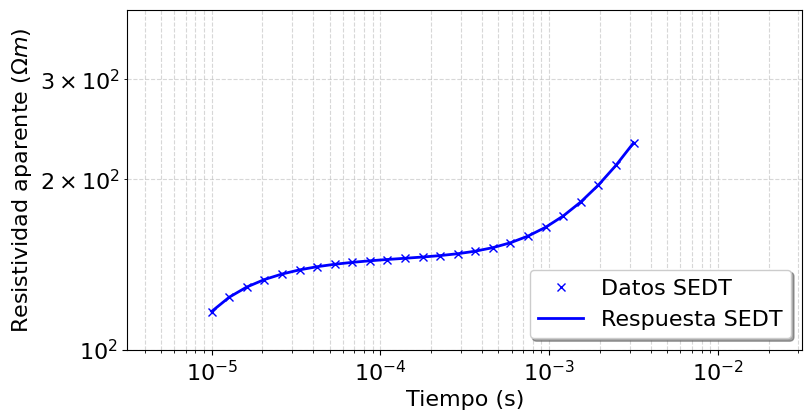

In [49]:
fig = plt.figure(figsize=(9, 4))
ax = fig.add_axes([0.1, 0.1, 0.75, 0.85])
ax.loglog(timesrhoa, rhoaTDEM, "bx", lw=2, label='Datos SEDT')
ax.loglog(times, rhoa_TDEM, "b-", lw=2, label='Respuesta SEDT')
ax.set_xlabel("Tiempo (s)")
ax.set_ylabel(r"Resistividad aparente ($\Omega m$)")

ax.set_ylim([10**2, 10**2.6])
ax.set_xlim([10**-5.5, 10**-1.5])
ax.grid(True, which="both", linestyle='--', alpha=0.5)  # Grilla sutil
plt.legend(loc='lower right', frameon=True, shadow=True, fancybox=True)

#plt.tight_layout()

filename = "DatosSEDT.png"
plt.savefig(filename, dpi=300, bbox_inches='tight', format='png')
plt.show()

In [35]:
f1 = 0.194 / times

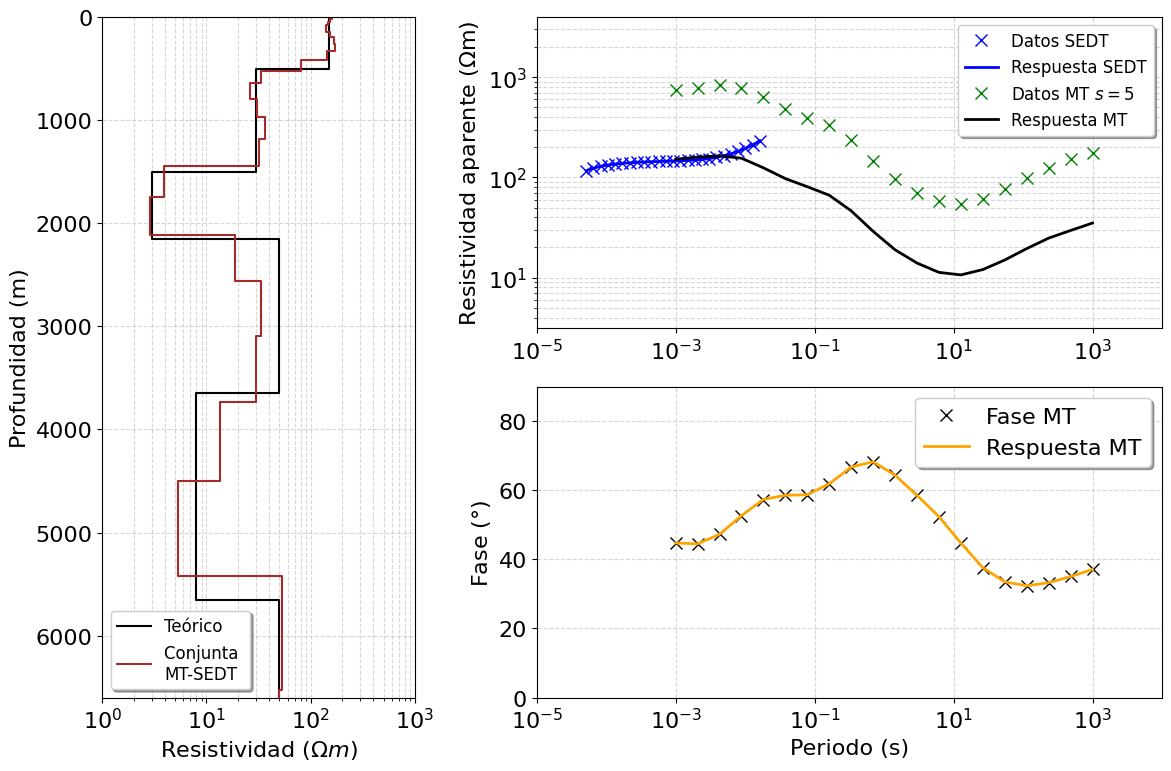

In [84]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

fig = plt.figure(figsize=(12, 8))  # Ajuste del tamaño para un modelo más largo
gs = gridspec.GridSpec(2, 2, figure=fig, width_ratios=[1, 2], height_ratios=[1,1])

# --- Izquierda: Modelo 1D de resistividades ---
ax1 = fig.add_subplot(gs[:2, 0])  # Modelo ocupa más espacio verticalmente
layer_tops = np.r_[0., -500., -1500., -2150., -3650., -5650.][::-1]  # en m
layer_thicknesses = np.diff(layer_tops)
rho_layers = np.r_[150., 30, 3., 50., 8., 50.][::-1]

plot_1d_layer_model(layer_thicknesses[::-1], rho_layers[::-1], ax=ax1, color="k", label="Teórico")
plot_1d_layer_model(
    layer_thicknesses_inv[::-1], (1/(sigma_map*recovered_model))[::-1], ax=ax1, color="brown", label="Conjunta \nMT-SEDT"
)
ax1.set_xlabel(r"Resistividad ($\Omega m$)")
ax1.set_ylabel("Profundidad (m)")
ax1.set_xlim(1e0, 1e3)
ax1.set_ylim([6600, 0])
ax1.grid(True, which="both", linestyle='--', alpha=0.5)
ax1.legend(frameon=True, shadow=True, fancybox=True, fontsize=12)

# --- Derecha arriba: Resistividad aparente ---
ax2 = fig.add_subplot(gs[0, 1])  # Más espacio para resistividad
ax2.loglog(1/f1, rhoaTDEM, "blue", marker='x', markersize=8, linestyle='none', label='Datos SEDT', lw=2)
ax2.loglog(1/fdpred, rhoa_TDEM, "b-", label='Respuesta SEDT', lw=2)
ax2.loglog(1/frequencies, (5*dobs.reshape((len(frequencies), 2))[:,0]), marker='x', markersize=8, linestyle='none', color='green', label='Datos MT $\mathit{s}=5$', lw=2)
ax2.loglog(1/frequencies, dobs_rhoaMT.reshape((len(frequencies), 2))[:, 0], color='black', label="Respuesta MT", lw=2)
ax2.set_ylim([10**0.5, 10**3.6])
ax2.set_xlim([10**-5, 10**4])
ax2.set_ylabel("Resistividad aparente ($\Omega$m)")
ax2.legend(loc='upper right', frameon=True, shadow=True, fancybox=True, fontsize=12)
ax2.grid(True, which="both", linestyle='--', alpha=0.5)

# --- Derecha abajo: Fase ---
ax3 = fig.add_subplot(gs[1, 1])  # Menos espacio para fase
ax3.semilogx(1/frequencies, dobs.reshape((len(frequencies), 2))[:,1], marker='x', linestyle='none', color='k', lw=2, label="Fase MT", markersize=8)
ax3.semilogx(1/frequencies, dpredMT, color='orange', label='Respuesta MT', lw=2)
ax3.set_xlabel("Periodo (s)")
ax3.set_ylabel("Fase ($\degree$)")
ax3.set_yticks(range(0, 90, 20))
ax3.set_ylim(0, 90)
ax3.set_xlim([10**-5, 10**4])
ax3.legend(loc='upper right', frameon=True, shadow=True, fancybox=True)
ax3.grid(True, which="both", linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig("MT-SEDT_sintetico.svg", dpi=300, bbox_inches='tight', format='svg')
plt.show()


In [67]:
# Calcular el desplazamiento estático

s = np.mean((5*dobs.reshape((len(frequencies), 2))[:,0])[:5] / (dobs_rhoaMT.reshape((len(frequencies), 2))[:, 0])[:5])

print(f"Desplazamiento s = {s:.3f}")

Desplazamiento s = 5.072


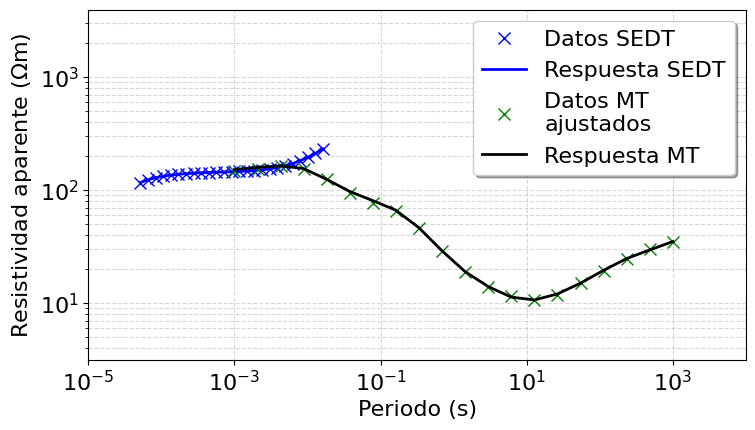

In [87]:
fig = plt.figure(figsize=(14, 10))  # Ajuste del tamaño para un modelo más largo
# --- Derecha arriba: Resistividad aparente ---
ax2 = fig.add_subplot(gs[0, 1])  # Más espacio para resistividad
ax2.loglog(1/f1, rhoaTDEM, "blue", marker='x', markersize=8, linestyle='none', label='Datos SEDT', lw=2)
ax2.loglog(1/fdpred, rhoa_TDEM, "b-", label='Respuesta SEDT', lw=2)
ax2.loglog(1/frequencies, 0.1971608832807571*(5*dobs.reshape((len(frequencies), 2))[:,0]), marker='x', markersize=8, linestyle='none', color='green', label='Datos MT \najustados', lw=2)
ax2.loglog(1/frequencies, dobs_rhoaMT.reshape((len(frequencies), 2))[:, 0], color='black', label="Respuesta MT", lw=2)
ax2.set_ylim([10**0.5, 10**3.6])
ax2.set_xlim([10**-5, 10**4])
ax2.set_ylabel("Resistividad aparente ($\Omega$m)")
ax2.set_xlabel("Periodo (s)")
ax2.legend(loc='upper right', frameon=True, shadow=True, fancybox=True)
ax2.grid(True, which="both", linestyle='--', alpha=0.5)

# Guardar la figura
filename = "MT_sint_ajustados.svg"
plt.savefig(filename, dpi=300, bbox_inches='tight', format='svg')